# Train a small model that can be used by the Starlette app to tell the difference between digits and non-digits.

The 2 main steps are;
- Use regression, rather than classification, so the model tells us how much digit it can find in the image
- Find the best value we can use to split the continuous output of the model into 2 groups (digits or not digits).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

See `not-digits-from-mnist.ipynb` for details of the "mnist_or_not" dataset.

In [3]:
path = untar_data(URLs.MNIST).parent/'mnist_or_not'

In [4]:
tfms = get_transforms(do_flip=False)

In [5]:
data = (ImageList.from_folder(path)
    .split_by_folder(train='training', valid='testing')
    .label_from_func(lambda x: 0. if 'not' in x.parts[-2] else 1.)
    .transform(tfms, size=28)
    .databunch(bs=256)
    .normalize(imagenet_stats))

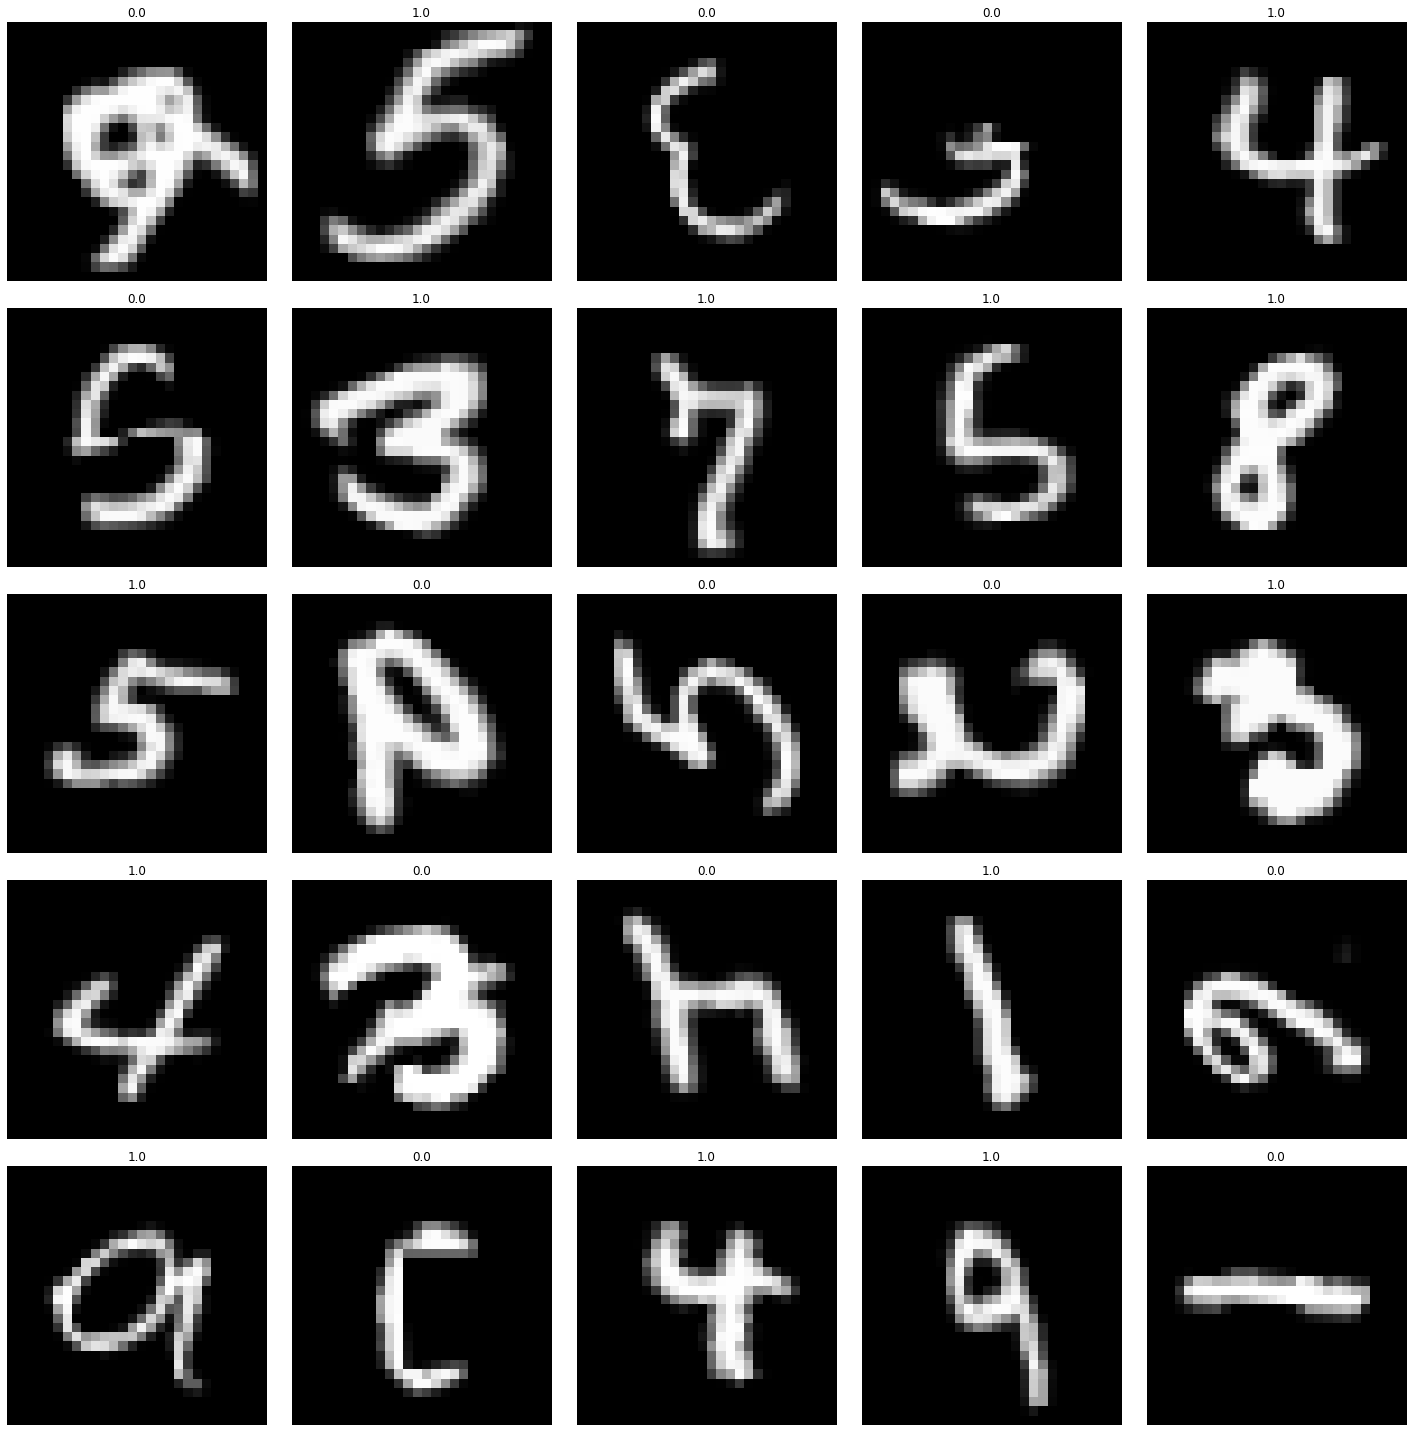

In [6]:
data.show_batch()

In [7]:
def conv_block(in_channels, out_channels, kernel_size, padding=0, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
        nn.ReLU(),
        nn.MaxPool2d((2,2)))

def fc_block(in_features, out_features):
    return nn.Sequential(
        nn.Linear(in_features, out_features),
        nn.ReLU())

# sigmoind reduced accuracy so we'll not use it
# while we're training the model to hit targets of 0 and 1, we don't care what 
# numbers the model outputs - as long as we can find an accurate threshold 
# class SigmoidWithRange(nn.Module):
#     def __init__(self, y_min=0, y_max=1):
#         super().__init__()
#         self.y_min,self.y_max=y_min,y_max        
#     def forward(self, x):
#         return (self.y_max-self.y_min) * torch.sigmoid(x) + self.y_min
# SigmoidWithRange(-0.1, 1.1)

def new_model():
    return nn.Sequential(
        conv_block(3, 32, 3, padding=2, stride=3),
        conv_block(32, 32, 3, padding=1),
        conv_block(32, 32, 3, padding=1),
        nn.Flatten(),
        fc_block(288, 84),
        nn.Linear(84, 1))

In [8]:
def _accuracy_thresh(y_pred:Tensor, y_true:Tensor, thresh:float=0.5)->Rank0Tensor:
    y_pred=torch.flatten(y_pred) # [bs,1] -> [bs]
    return ((y_pred>thresh).byte()==y_true.byte()).float().mean()

learn = Learner(data, new_model(), metrics=_accuracy_thresh)

In [9]:
learn.summary() # Loss function: FlattenedLoss of MSELoss()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [32, 30, 30]         896        True      
______________________________________________________________________
ReLU                 [32, 30, 30]         0          False     
______________________________________________________________________
MaxPool2d            [32, 15, 15]         0          False     
______________________________________________________________________
Conv2d               [32, 15, 15]         9,248      True      
______________________________________________________________________
ReLU                 [32, 15, 15]         0          False     
______________________________________________________________________
MaxPool2d            [32, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 7, 7]           9,248      True      
___________________________________________________

epoch,train_loss,valid_loss,_accuracy_thresh,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


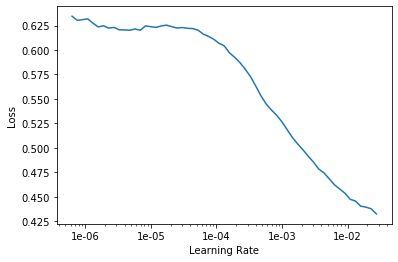

In [10]:
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,_accuracy_thresh,time
0,0.089190,0.172238,0.893750,00:24
1,0.069223,0.064700,0.926600,00:23
2,0.057522,0.048261,0.946750,00:23
3,0.044695,0.050801,0.935400,00:24
4,0.039086,0.044799,0.943700,00:24


Note: When compared with `mnist-training.ipynb`, we do 10 times as much tranining (5x epochs, 2x data).
Any less than this and the model seems to make a lot of mistakes when tested via the UI.
We could 
TODO: quantify and test the effectiveness of

## Find the most accurate threshold value

What is the best value of `thresh` we can use to split predictions into 2 groups (digits or not digits).

Plotting preds vs actuals shows us the most accurate split will be ~0.4

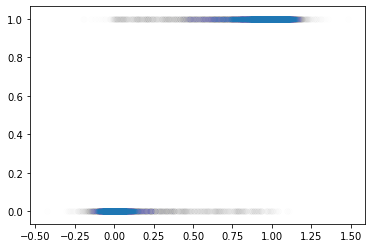

In [12]:
y_preds,y_actuals=[],[]
with torch.no_grad():
    for i, (xb, yb) in enumerate(data.valid_dl):
        y_pred = learn.model(xb)
        y_pred = torch.flatten(y_pred)
        y_preds.append(y_pred)
        y_actuals.append(yb)
y_preds,y_actuals=torch.cat(y_preds),torch.cat(y_actuals)
plt.scatter(y_preds.cpu(), y_actuals.cpu(), alpha=.005);

Try to find the best `thresh` value by;
- starting with a wide range (0 to 1) and wide steps 0.1 then
- searching a smaller range, near the best value found (e.g. 0.7 to 0.9), using smaller steps (e.g. 0.02)
- and repeating the above `max_depth` times

In [13]:
def search_optimal_thresh(start, step, result=[0], depth=0, max_depth=3):
    for i in range(11):
        thresh=(i*step)+start
        acc=_accuracy_thresh(y_preds, y_actuals, thresh).item()
        if acc>result[0]: result=[acc,thresh]
    if depth<max_depth:
        return search_optimal_thresh(result[1]-step, step/5, result, depth+1)
    return result

opt_acc,opt_thresh=search_optimal_thresh(0, .1)
print(f'Using threshold of {round(opt_thresh,3)} gives us an accuaracy of {round(opt_acc, 3)}')

Using threshold of 0.382 gives us an accuaracy of 0.948


In [14]:
# we'll need access to the best thresh value at inference time
learn.model.opt_thresh=round(opt_thresh,3)

## Save everything needed to make predictions

In [15]:
# remove metrics so we don't need `_accuracy_thresh` available at inference time
learn.metrics=[]
learn.save('mnist-or-not-learn')
# export the model for inference
learn_export_file_name = 'mnist-or-not-learn-export.pkl'
learn.export(learn_export_file_name)
# Export the minimal state of the data bunch for inference 
data_export_file_name = 'mnist-or-not-data-export.pkl'
data.export(data_export_file_name)

In [16]:
import shutil
here = Path('.')
# copy the export files from fastai default to here
for file_name in [learn_export_file_name, data_export_file_name]:
    shutil.copyfile(path/file_name, here/file_name)

### See if the model is consistently accurate across classes of digits

In [17]:
d = []
data = DataBunch.load_empty(path, data_export_file_name)
data.batch_size=2048
for cls in range(10):
    image_list = ImageList.from_folder(path/f'testing/{cls}')
    data.add_test(image_list)
    xb, _ = next(iter(data.test_dl))
    output = learn.model(xb).flatten()
    d.append([cls]+[(output>t).sum().item()/len(xb) for t in [opt_thresh-.1, opt_thresh, opt_thresh+.1]])

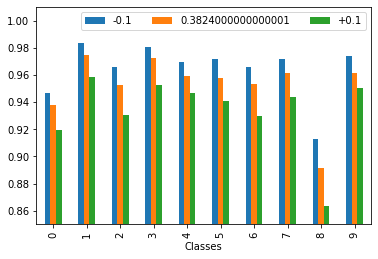

In [18]:
df = pd.DataFrame(d, columns=['Class', '-0.1', opt_thresh, '+0.1'])
df.plot.bar(x='Class', ylim=(.85,1.01)); plt.legend(ncol=3); plt.xlabel('Classes');